# Software Verification Quick Guide XmR Chart

This notebook is an addendum resource to the *Software Verification Quick Guide*. The quick guide can be downloaded at www.brokenquality.com/resources. 

When evaluating if a software package calculates process limits for an XmR chart correctly (i.e., it uses the 2.660 and 3.268 scaling factors and average moving range), the process limits and XmR chart calculated in this notebook should be used as verification and reference. If the computed limits from software differ from the limits calculated here, questions should be asked. 

With this said, if you are reading these words it is highly likely that you are capable of generating an XmR chart using Python. If that is the case, please feel free to use **process_improvement.py** library. This library is avalible on pypi.org and can be ```pip``` installed.

If you have questions about software verification or process behavior charts in general email **James.Lehner@gmail.com** or **QualityIsBroken@gmail.com**.

In [46]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline

## Get the data

In [47]:
# Establish the dataset_url
dataset_url = r'https://raw.githubusercontent.com/jimlehner/broken-quality-initiative/refs/heads/main/verification-datasets/software-verification-quick-guide-dataset.csv'

# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
df = get_data(dataset_url)

# Specify 'Sample' column as dtype string
df['Sample'] = df['Sample'].astype('string')

# Drop 'Notes' column
df = df.drop('Notes', axis=1)

# Show df
df.head()

,Sample,X,mR
0,1,5045,NaN
1,2,4350,695.0
2,3,4350,0.0
3,4,3975,375.0
4,5,4290,315.0


## Calculate the process staitstics

In [48]:
# Specify round_value 
round_value = 1

# Average moving range
ave_mR = round(df['mR'].mean(), round_value)

# Mean
mean = round(df['X'].mean(), round_value)

# Upper Process Limit (UPL)
UPL = round(mean + (2.660*ave_mR), round_value)

# Lower Process Limit (LPL)
LPL = round(mean - (2.660*ave_mR), round_value)

# Upper Range Limit (URL)
URL = round(3.268*ave_mR, round_value)

# Create stats dictionary
stats = {
    "Mean": mean,
    "Ave. mR": ave_mR,
    "UPL": UPL,
    "LPL": LPL,
    "URL": URL
}

# Print process statistics
for name, value in stats.items():
    print(f"  {name:<8}: {value:.1f}")

  Mean    : 4135.5
  Ave. mR : 355.9
  UPL     : 5082.2
  LPL     : 3188.8
  URL     : 1163.1


## Create XmR chart

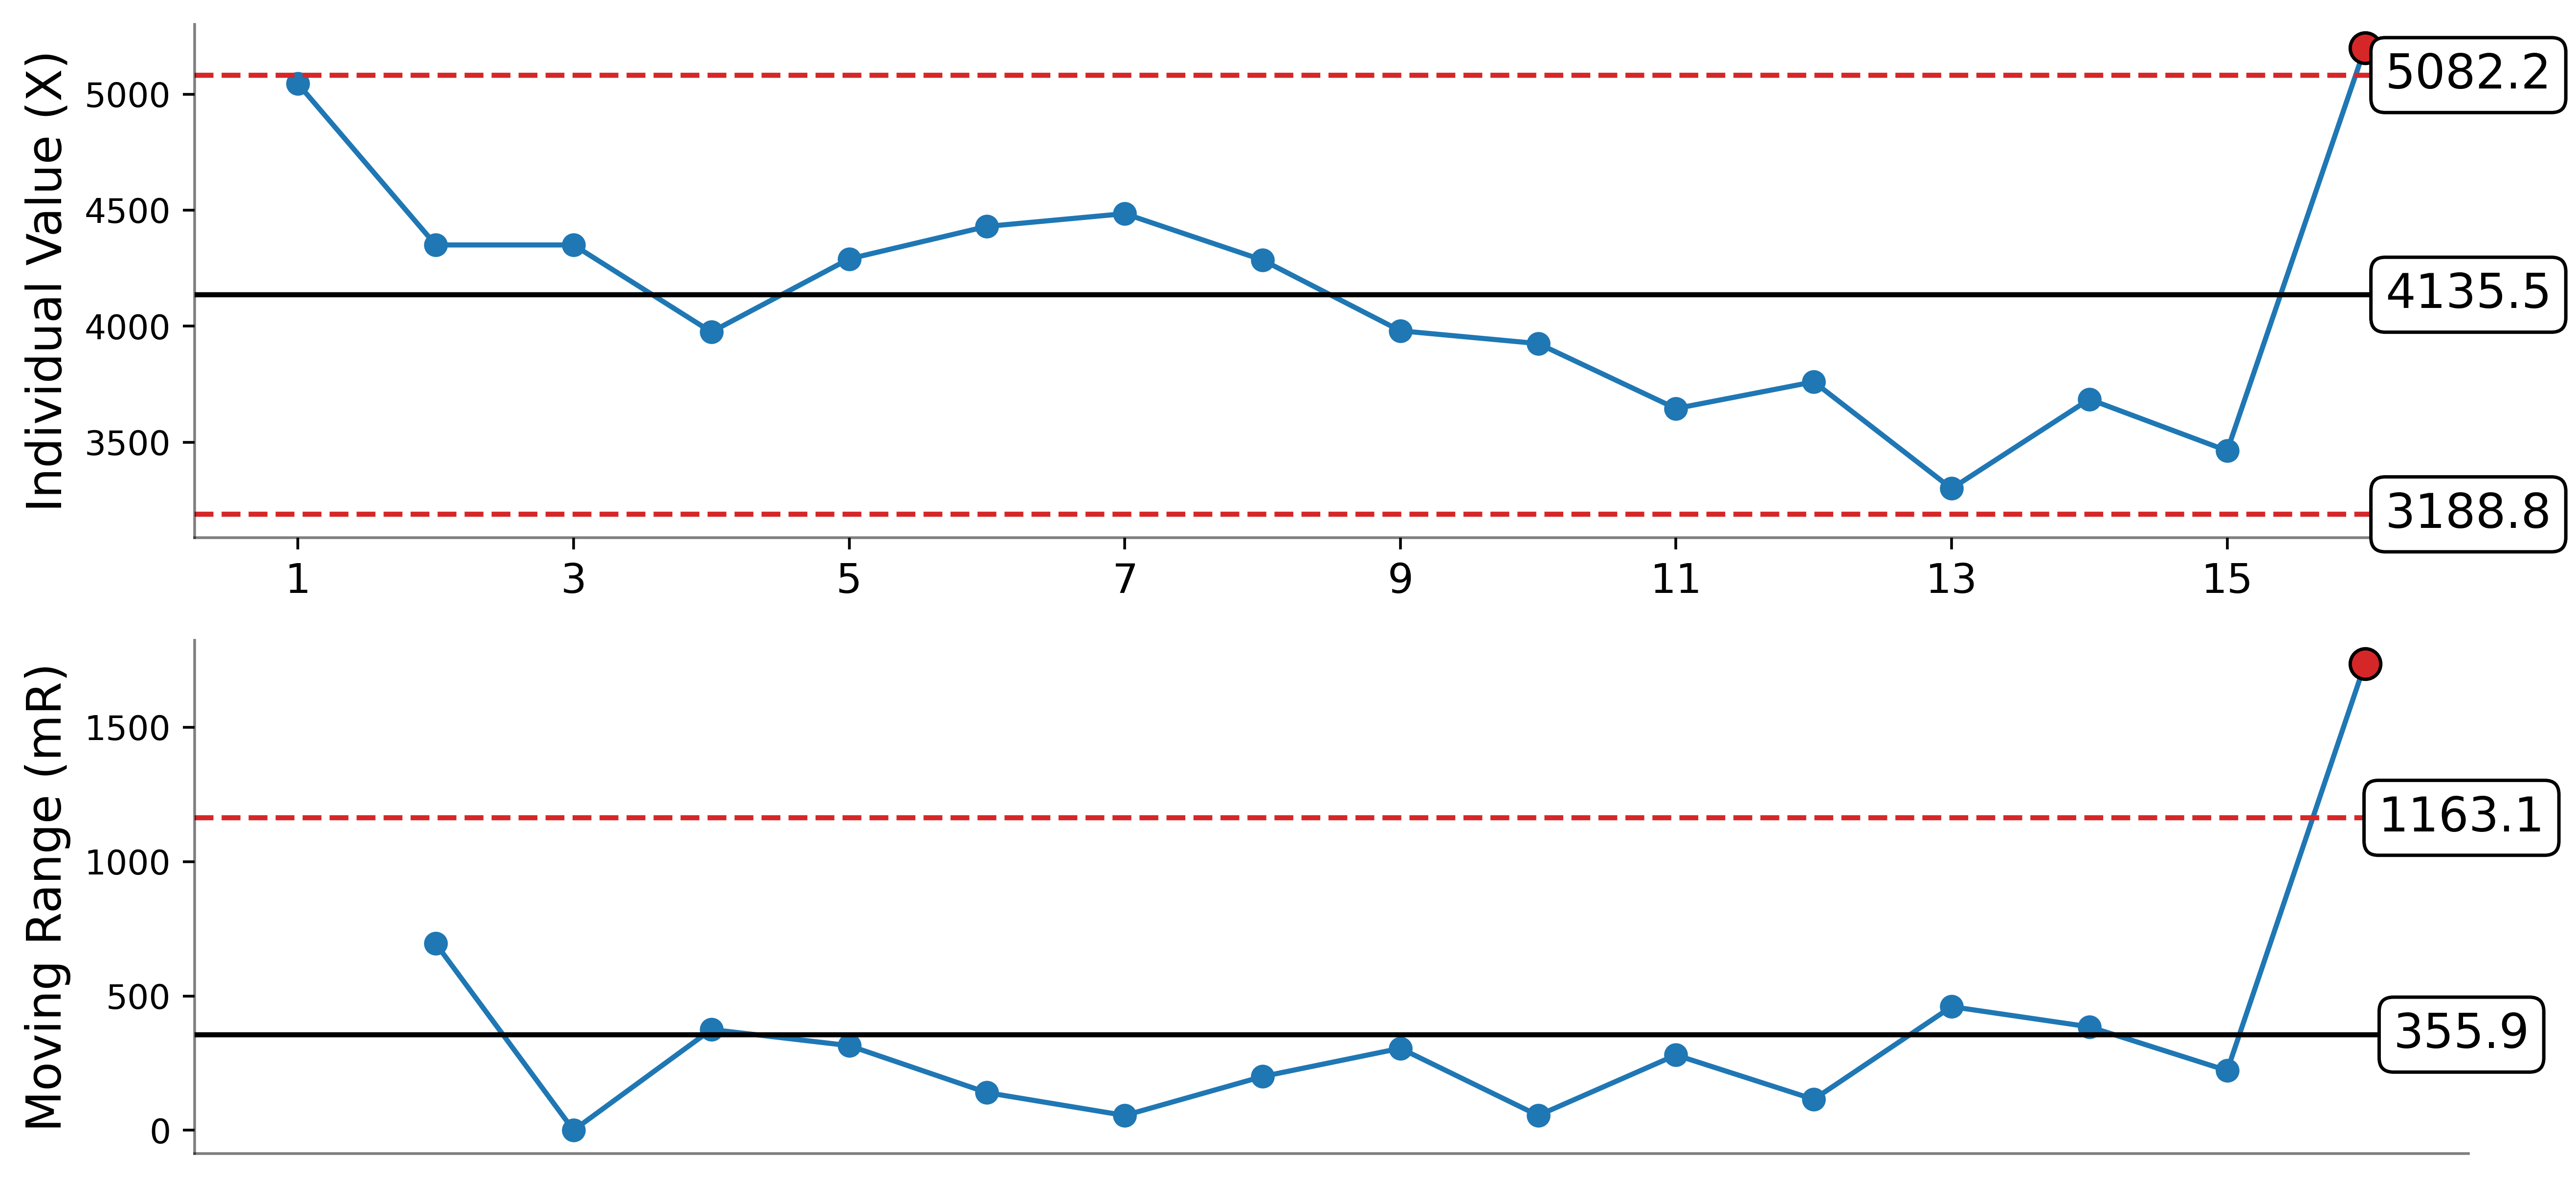

In [49]:
# Specify tickinterval
tickinterval = 2

# Specify data and labels
data = df['X']
labels = df['Sample']
moving_ranges = df['mR']

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'-','black'), (UPL,'--','tab:red'), (LPL,'--','tab:red')]
mrchart_lines = [(ave_mR,'-','black'), (URL,'--','tab:red')]

# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(ave_mR, ave_mR)]

# Create figure and axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,6), dpi=500)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
# Add masking parameters to color values greater than URL
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, UPL, color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, LPL, color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], mean, mean, color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

axs[1].text(axs[1].get_xlim()[1], URL, URL, color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], ave_mR, ave_mR, color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, line, color in xchart_lines:
    axs[0].axhline(value, ls=line, c=color)
    
# Add centerline and process limits 
for value, line, color in mrchart_lines:
    axs[1].axhline(value, ls=line, c=color)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', fontsize=12)
# Remove ticks on axs[1]
axs[1].set_xticks([])

# Color values in the moving range white (applies to first value for visual offset)
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Individual Value (X)", fontsize=14)
axs[0].set_title("", fontsize=14)

axs[1].set_xlabel("")
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Specify spine visibility 
sns.despine()
for val in (0,1):
    axs[val].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()